In [1]:
# !conda install -c pytorch torchvision
# !pip install datasets

In [2]:
from datasets import *
from datetime import datetime

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
import torch.cuda
torch.manual_seed(0)

import time
import copy

In [3]:
cifar_dataset = load_dataset("cifar10")

In [4]:
display(cifar_dataset["train"][:32])

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RG

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cuda:0


In [127]:
def plot_cost_accuracy(cost, acc) :
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('Iteration', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()
    color='tab:green'
    ax2.plot(acc, color=color)
    ax2.set_xlabel('Iteration', color=color)
    ax2.set_ylabel('Accuracy', color=color)
    ax2.tick_params(axis='y', color=color)
    
    fig.tight_layout()
    plt.title("Cost v Accuracy Over Epochs")
    plt.show()

In [7]:
train_set = cifar_dataset["train"]
validation_set = cifar_dataset["test"]

In [8]:
print(train_set)

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})


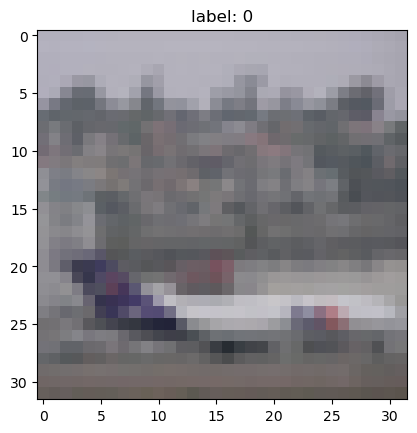

In [9]:
plt.title('label: ' + str(train_set[0]['label']))
imshow(train_set[0]['img'])

In [10]:
n_epochs = 10
batch_size=16
lr=0.00001
momentum=0.9
base_lr=0.001
max_lr=0.01

In [106]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True) :
    loss_list=[]
    accuracy_list=[]
    correct=0
    
    n_tests = len(validation_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm(range(n_epochs)) :
        loss_sublist=[]
        
        for img, label in train_loader :
            img, label = img.to(device), label.to(device)
            model.train()
            
            z = model(img)
            loss = criterion(z, label.flatten())
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()
            
        print("epoch", epoch, " done")
        
        scheduler.step()
        loss_list.append(np.mean(loss_sublist))
        correct = 0
        
        for img, label in validation_loader :
            img, label = img.to(device), label.to(device)
            #img, label = i['img'], i['label']
            model.eval()
            
            z=model(img)
            _, yhat = torch.max(z.data, 1)
            
            correct += (yhat == label).sum().item()
        accuracy = correct / n_tests
        accuracy_list.append(accuracy)
        
        if accuracy > accuracy_best :
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            
        if print_ :
            print("The learning rate is ", optimizer.param_groups[0]['lr'])
            print("The validation cost for epoch " + str(epoch + 1) + ": " +str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))
            
    model.load_state_dict(best_model_wts)
    
    return accuracy_list, loss_list, model

In [15]:
criterion = nn.CrossEntropyLoss()

In [113]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

convert_tensor = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(mean=means,std=stds)#,
                                     #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3))
                       ])

In [114]:
tr_img = torch.tensor(train_set.map(lambda e : {'img' : convert_tensor(e['img']), 'label' : e['label']})['img'])
tr_lbl = torch.tensor(train_set['label']).reshape(-1, 1)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [115]:
val_img = torch.tensor(validation_set.map(lambda e : {'img' : convert_tensor(e['img']), 'label' : e['label']})['img'])
val_lbl = torch.tensor(validation_set['label']).reshape(-1, 1)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [116]:
torch.Tensor.size(tr_img)

torch.Size([50000, 3, 32, 32])

In [117]:
torch.Tensor.size(val_img)

torch.Size([10000, 3, 32, 32])

In [118]:
train_loader = DataLoader(dataset = list(zip(tr_img, tr_lbl)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset= list(zip(val_img, val_lbl)), batch_size=1)

In [119]:
len(train_loader), len(val_loader)

(3125, 10000)

In [102]:
for i, v in train_loader :
    print(i, v.flatten())
    print(type(i[0]))
    break
    
for i, v in val_loader :
    print(i, v.flatten())
    print(type(i[0]))
    break

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  1.5982,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.7654,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [120]:
model = models.resnet18(pretrained=True)
for param in model.parameters() :
    param.requires_grad=False
model.fc = nn.Linear(512, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [121]:
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=5, mode="triangular2")

In [122]:
start_datetime = datetime.now()
start_time = time.time()

acc_list, loss_list, model = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
print("time elapsed", current_time - start_time)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

epoch 0  done


 10%|████████▏                                                                         | 1/10 [01:59<17:51, 119.06s/it]

The learning rate is 0.002800000000000002
The validation cost for epoch 1: 1.7994675396347046
The validation accuracy for epoch1: 0.4148
epoch 1  done


 20%|████████████████▍                                                                 | 2/10 [04:00<16:04, 120.61s/it]

The learning rate is 0.0046
The validation cost for epoch 2: 1.9752260441398621
The validation accuracy for epoch2: 0.3827
epoch 2  done


 30%|████████████████████████▌                                                         | 3/10 [06:01<14:03, 120.46s/it]

The learning rate is 0.006400000000000001
The validation cost for epoch 3: 2.2151631265830996
The validation accuracy for epoch3: 0.3402
epoch 3  done


 40%|████████████████████████████████▊                                                 | 4/10 [08:02<12:04, 120.77s/it]

The learning rate is 0.008199999999999999
The validation cost for epoch 4: 2.4210747250938414
The validation accuracy for epoch4: 0.3689
epoch 4  done


 50%|█████████████████████████████████████████                                         | 5/10 [10:03<10:04, 120.95s/it]

The learning rate is 0.010000000000000002
The validation cost for epoch 5: 2.6066769093322755
The validation accuracy for epoch5: 0.3456
epoch 5  done


 60%|█████████████████████████████████████████████████▏                                | 6/10 [12:05<08:04, 121.24s/it]

The learning rate is 0.008199999999999999
The validation cost for epoch 6: 2.7543315676498414
The validation accuracy for epoch6: 0.3268
epoch 6  done


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [14:08<06:05, 121.95s/it]

The learning rate is 0.006400000000000001
The validation cost for epoch 7: 2.621807771034241
The validation accuracy for epoch7: 0.3771
epoch 7  done


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [16:11<04:04, 122.29s/it]

The learning rate is 0.0046
The validation cost for epoch 8: 2.4431961700439455
The validation accuracy for epoch8: 0.3604
epoch 8  done


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [18:23<02:05, 125.13s/it]

The learning rate is 0.002800000000000002
The validation cost for epoch 9: 2.2577330005836487
The validation accuracy for epoch9: 0.3484
epoch 9  done


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:27<00:00, 122.72s/it]

The learning rate is 0.001
The validation cost for epoch 10: 2.008562376937866
The validation accuracy for epoch10: 0.3762
time elapsed 1227.2561671733856


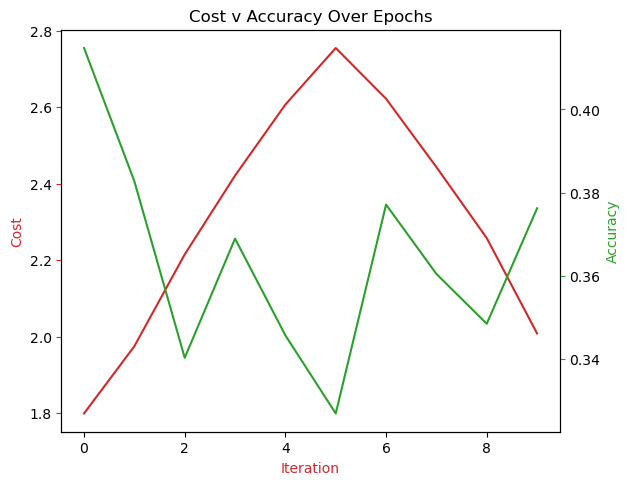

In [128]:
plot_cost_accuracy(loss_list, acc_list)

C:\Users\avida\AppData\Local\Temp\ipykernel_2224\3946639857.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_img = torch.tensor((convert_tensor(plane)).to(device)).unsqueeze(0)


torch.Size([1, 3, 32, 32])
ship


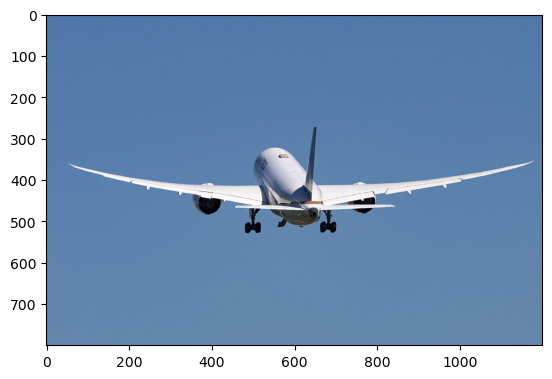

In [139]:
model.eval()

plane = Image.open("plane.jpg")

convert_tensor = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

tensor_img = torch.tensor((convert_tensor(plane)).to(device)).unsqueeze(0)

imshow(plane)

print(torch.Tensor.size(tensor_img))

z = model(tensor_img)

classes = {0 : "airplane", 1 : "automobile", 2 : "bird", 3 : "cat", 4 : "deer", 5 : "dog", 6 : "frog", 7 : "horse", 8 : "ship", 9 : "truck"}

_, yhat = torch.max(z.data, 1)

for i in classes :
    if (yhat == i) :
        print(classes.get(i))
        break